<img style="float: left; margin: 30px 15px 15px 15px;" src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTFzQj91sOlkeDFkg5HDbjtR4QJYmLXkfMNig&usqp=CAU" width="400" height="500" /> 
    
    
### <font color='navy'> Modelos no lineales para pronósticos. 

**Nombres:** Xander Gallegos, Carlos Emiliano Rodríguez.

**Fecha:** 15 de febrero del 2024.

**Expediente** : 737989, XXXXXX.
    
**Profesor:** Oscar David Jaramillo Zuluaga.
    
**Link Github**: <a href=https://github.com/xagallegos/ProyectoConjunto_XGallegos_CERodriguez>ProyectoConjunto_XGallegos_CERodriguez</a>

# Tarea 3: Clase 7

## Enunciado de tarea 

> Condensar todos los procedimientos realizados en esta clase donde se implementen los métodos necesarios para crear un correcto flujo de lectura de datos, análisis, ajuste de parámetros, predicción y métricas de errores para un conjunto de datos dado.

> Implementar los métodos y las lógicas que consideren pertinentes, como de igual forma las posibles variables a introducir en el constructor de la clase. Posteriormente, utilizar la clase anteriormente creada para generar un modelo SARIMAX para el siguiente conjunto de datos: <https://github.com/quaesito/time-series-forecast-sarimax-prophet/blob/master/A4.xlsx?raw=true>

### Ejercicio 1: Condensar todos los procedimientos realizados en esta clase donde se implementen los métodos necesarios para crear un correcto flujo de lectura de datos, análisis, ajuste de parámetros, predicción y métricas de errores para un conjunto de datos dado.

Código de solución estudiante 1

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import MSTL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from io import BytesIO
from sklearn.preprocessing import power_transform, MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_percentage_error

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Código de solución estudiante 1
class LinearForecast:
    def __init__(self, file_path, file_type='csv', kwargs = dict(), train_split=0.8):
        if file_type == 'csv':
            self.data = pd.read_csv(file_path, **kwargs)
        elif file_type == 'xlsx':
            self.data = pd.read_excel(file_path, **kwargs)
        else:
            raise ValueError(f'Unexpected value "{file_type}"')

    def seasonal_decomposition(self, periods_seasonality, plot=False):
        decomposition_model = MSTL(self.data.copy(), periods=periods_seasonality, stl_kwargs={"seasonal_deg": 0} )
        result = decomposition_model.fit()
        self.periods = periods_seasonality
        self.decomposed_series = result
        
        if plot is True:
            n = 3 + len(periods_seasonality)
            fig, axes = plt.subplots(n, 1, figsize=(8,8))
            
            result.observed.plot(ax=axes[0])
            axes[0].set_ylabel('Observed')

            result.trend.plot(ax=axes[1])
            axes[1].set_ylabel('Trend')

            for i, period in enumerate(periods_seasonality):
                result.seasonal[f'seasonal_{period}'].plot(ax=axes[2+i])
                axes[2+i].set_ylabel(f'seasonal_{period}')

            result.resid.plot(ax=axes[-1])
            axes[-1].set_ylabel('Residual')

            fig, ax = plt.subplots(figsize=(8,4))
            result.observed.plot(label='observados', ax=ax)

            for period in periods_seasonality:
                result.seasonal[f'seasonal_{period}'].plot(ax = ax, label=f'seasonal_{period}')
            
            plt.legend()
            plt.show()
        
    def  plot_non_seasonal(self):
        self.non_seasonal = self.decomposed_series.observed
        for period in self.periods:
            self.non_seasonal -= self.decomposed_series.seasonal[f'seasonal_{period}']

        fig = plt.figure(figsize=(8,4))
        self.non_seasonal.plot(label='non_seasonal')
        self.decomposed_series.observed.plot(label='observed')
        plt.legend()
        plt.show()

    
    def adf_test(self, seasonal_period=False, diff=0):
        if seasonal_period is False:
            data = self.data
        elif seasonal_period == 'non_seasonal':
            data = self.non_seasonal
        else:
            data = self.decomposed_series.seasonal[seasonal_period]
        
        for i in range(diff):
            data = data.diff().dropna()
            
        dftest = adfuller(data, autolag = "AIC")
        dfoutput = pd.Series(dftest[0:4],
                             index = ["Test Statistic",
                                      "p-value",
                                      "#Lags Used",
                                      "Number of Observations Used"])
        
        for key, value in dftest[4].items():
            dfoutput["Critical Value (%s)" % key] = value
            
        print(f"Results of Dickey-Fuller Test: (diff: {diff})")
        print(dfoutput)
        
        if (dftest[1] <= 0.05) & (dftest[4]['5%'] > dftest[0]):
            print("\u001b[32mStationary\u001b[0m")
        else:
            print("\x1b[31mNon-stationary\x1b[0m")
            
    def plot_acf_pac(self, diff=0, seasonal_period=False, kwargs=dict()):        
        if seasonal_period is False:
            data = self.data
        elif seasonal_period == 'non_seasonal':
            data = self.non_seasonal
        else:
            data = self.decomposed_series.seasonal[seasonal_period]
        
        for i in range(diff):
            data = data.diff().dropna()
        
        f = plt.figure(figsize=(10,3))

        ax1 = f.add_subplot(121)
        plot_acf(data, zero=False, ax=ax1, **kwargs)
    
        ax2 = f.add_subplot(122)
        plot_pacf(data, zero=False, ax=ax2, method='ols', **kwargs)
    
        plt.show()

    def transform_timeseries(self, how='sqrt'):
        if how == 'sqrt':
            return np.sqrt(self.data)
        elif how == 'log':
            return np.log(self.data)
        elif how in ['box-cox', 'yeo-johnson']:
            return power_transform(self.data.to_numpy().reshape(-1,1), method=how)
        elif how == 'min-max-scaler':
            scaler = MinMaxScaler()
            return mm_scaler.fit_transform(self.data)
        elif how == 'std-scaler':
            scaler = StandardScaler()
            return scaler.fit_transform(self.data.values.reshape(-1, 1))
        else:
            raise ValueError(f'Unexpected value "{how}"')

    def sarimax_model(self, params):
        non_seasonal, seasonal, trend = params
        model = SARIMAX(
            endog = self.data,
            trend = trend,
            order = non_seasonal,
            seasonal_order = seasonal
        )
        self.model = model.fit()

    def predict(self, start, end, model='last', plot=False):
        if model == 'last':
            model = self.model
            
        y_h = model.predict(start=start, end=end)

        if plot is True:
            fig = plt.figure()
            self.data.iloc[self.data.index >= start].plot(label='data')
            y_h.plot(label='pred')
            plt.legend()
            plt.show()
            
        return y_h
    
    def eval_model(self):
        y_h = self.model.predict()

        mape = mean_absolute_percentage_error(y_true = self.data, y_pred=y_h)
        mad = np.mean(np.abs(np.subtract(self.data, y_h)))
        return mape, mad
        

Código de solución estudiante 2

In [3]:
# Código de solución estudiante 2

### Ejercicio 2: Implementar los métodos y las lógicas que consideren pertinentes, como de igual forma las posibles variables a introducir en el constructor de la clase. Posteriormente, utilizar la clase anteriormente creada para generar un modelo SARIMAX para el siguiente conjunto de datos: <https://github.com/quaesito/time-series-forecast-sarimax-prophet/blob/master/A4.xlsx?raw=true>

Código de solución de estudiante 1

In [4]:
# Código de solución de estudiante 1
file = 'https://github.com/quaesito/time-series-forecast-sarimax-prophet/blob/master/A4.xlsx?raw=true'
forecast = LinearForecast(file, 'xlsx')

In [5]:
def prepare_df(df):
    # Sumar fecha y hora
    df.date = [d + pd.Timedelta(h, unit='hour') for d, h in df[['date', 'hour']].values]
    df.set_index('date', inplace=True) # asignarla como índice
    
    # Conservar únicamente la fecha y la columna a predecir -> energía
    df.drop(columns = [c for c in df.columns if c != 'Energy (kWh)'], inplace=True)

    # Resample por promedio del mes
    df = df.resample('m').mean()
    return df

In [6]:
forecast.data = prepare_df(forecast.data)

print(forecast.data.shape)
forecast.data.head()

(300, 1)


,Energy (kWh)
date,
1990-01-31,451.887005
1990-02-28,423.897505
1990-03-31,430.298776
1990-04-30,296.197605
1990-05-31,288.352006


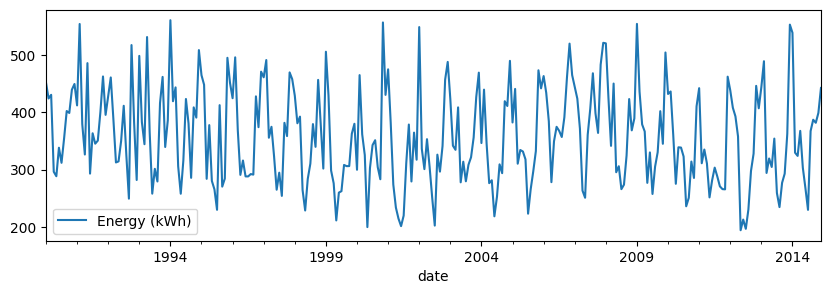

In [7]:
# Graficar la serie de tiempo
forecast.data.plot(figsize=(10,3))
plt.show()

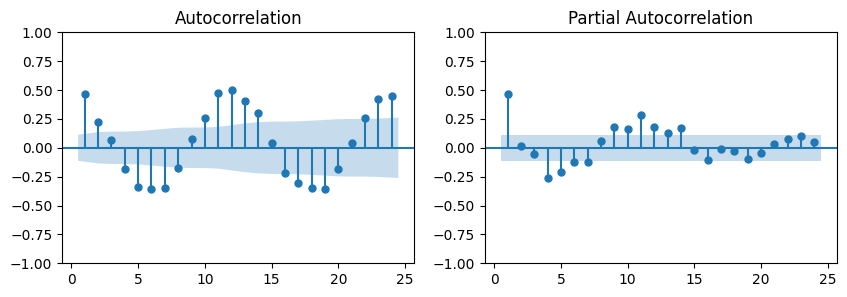

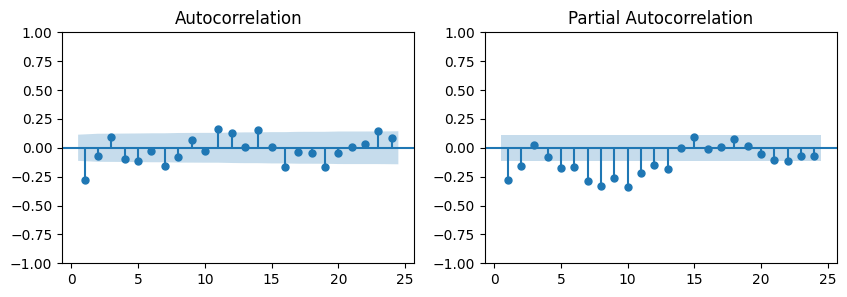

In [8]:
# Graficar ACF y PAC
forecast.plot_acf_pac(kwargs={'lags': 24})
forecast.plot_acf_pac(diff=1, kwargs={'lags': 24})
# forecast.plot_acf_pac(diff=2, kwargs={'lags': 24})

In [9]:
forecast.adf_test()
forecast.adf_test(diff=1)
# forecast.adf_test(diff=2)

Results of Dickey-Fuller Test: (diff: 0)
Test Statistic                  -2.242267
p-value                          0.191264
#Lags Used                      13.000000
Number of Observations Used    286.000000
Critical Value (1%)             -3.453423
Critical Value (5%)             -2.871699
Critical Value (10%)            -2.572183
dtype: float64
Non-stationary
Results of Dickey-Fuller Test: (diff: 1)
Test Statistic                -1.185352e+01
p-value                        7.115964e-22
#Lags Used                     1.200000e+01
Number of Observations Used    2.860000e+02
Critical Value (1%)           -3.453423e+00
Critical Value (5%)           -2.871699e+00
Critical Value (10%)          -2.572183e+00
dtype: float64
Stationary


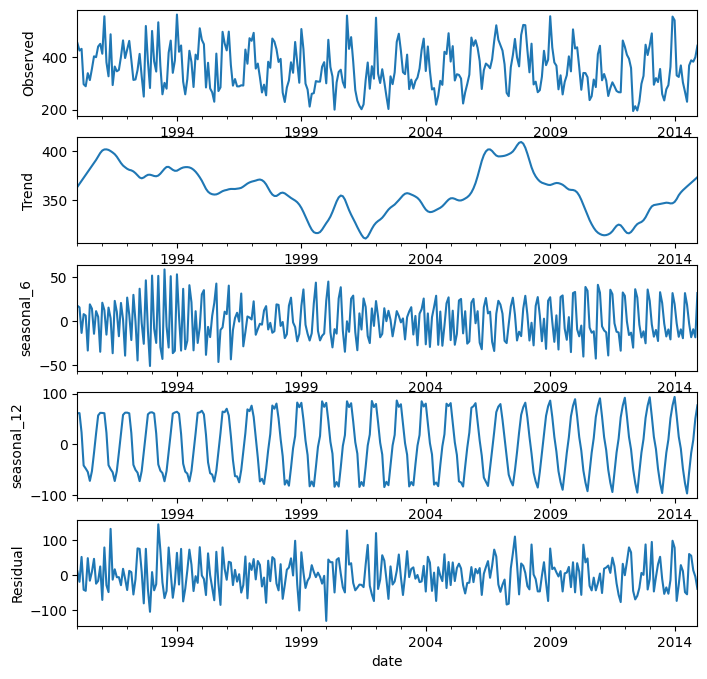

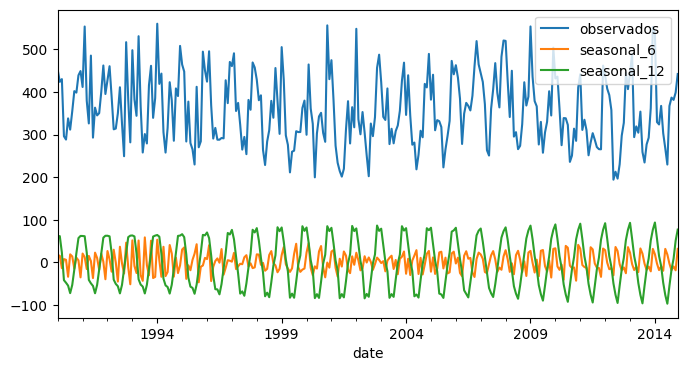

In [10]:
forecast.seasonal_decomposition((6,12), plot=True)

**Componente estacional**

In [11]:
forecast.adf_test(seasonal_period = 'seasonal_12')
# forecast.adf_test(diff=1, seasonal_period = 'seasonal_12')
# forecast.adf_test(diff=2, seasonal_period = 'seasonal_12')

Results of Dickey-Fuller Test: (diff: 0)
Test Statistic                 -29.256349
p-value                          0.000000
#Lags Used                      16.000000
Number of Observations Used    283.000000
Critical Value (1%)             -3.453670
Critical Value (5%)             -2.871808
Critical Value (10%)            -2.572241
dtype: float64
Stationary


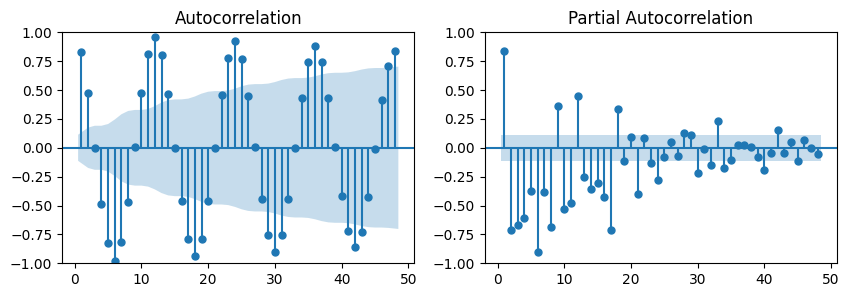

In [12]:
forecast.plot_acf_pac(seasonal_period='seasonal_12', kwargs={'lags':48})
# forecast.plot_acf_pac(diff=1, seasonal_period='seasonal_12', kwargs={'lags':48})
# forecast.plot_acf_pac(diff=2, seasonal_period='seasonal_12', kwargs={'lags':48})

$(P, D, Q) = (2, 0, 2)$

**Componente no estacional**

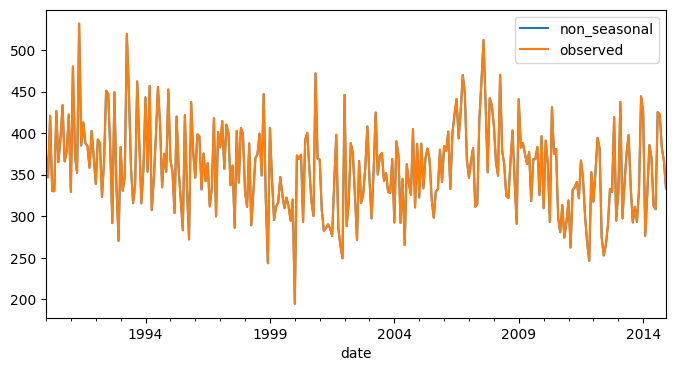

In [13]:
forecast.plot_non_seasonal()

In [14]:
forecast.adf_test(seasonal_period='non_seasonal')
forecast.adf_test(diff=1, seasonal_period='non_seasonal')

Results of Dickey-Fuller Test: (diff: 0)
Test Statistic                  -2.652388
p-value                          0.082646
#Lags Used                      13.000000
Number of Observations Used    286.000000
Critical Value (1%)             -3.453423
Critical Value (5%)             -2.871699
Critical Value (10%)            -2.572183
dtype: float64
Non-stationary
Results of Dickey-Fuller Test: (diff: 1)
Test Statistic                -7.982167e+00
p-value                        2.605812e-12
#Lags Used                     1.300000e+01
Number of Observations Used    2.850000e+02
Critical Value (1%)           -3.453505e+00
Critical Value (5%)           -2.871735e+00
Critical Value (10%)          -2.572202e+00
dtype: float64
Stationary


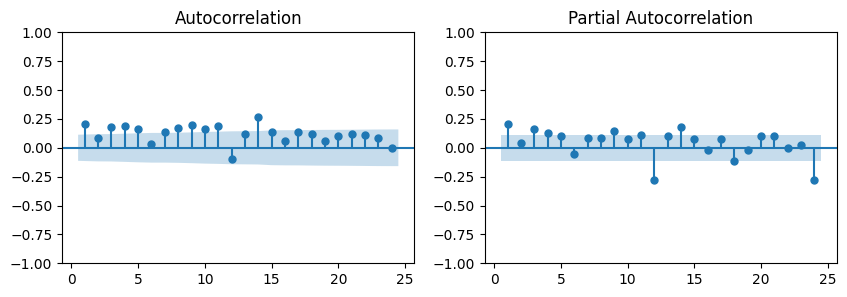

In [15]:
forecast.plot_acf_pac(seasonal_period='non_seasonal', kwargs={'lags':24})

$(p, d, q) = (0, 1, 0)$

**Model and predictions**

<Figure size 640x480 with 0 Axes>

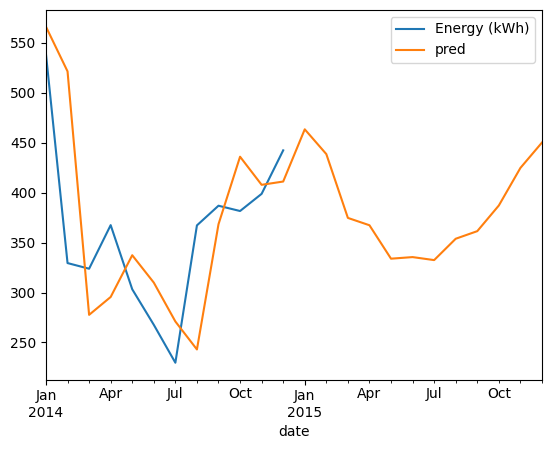

In [16]:
forecast.sarimax_model(((0,1,0), (2,0,2,12), 'n'))
y_h = forecast.predict(start='2014-01-31', end='2015-12-31', plot=True)

In [17]:
mape, mad = forecast.eval_model()

print(f'>> mape: {mape}')
print(f'>> mad:  {mad}')

>> mape: 0.17957397655676177
>> mad:  nan


Código de solución de estudiante 2

In [18]:
# Código de solución de estudiante 2